# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *

np.random.seed(2512517)

## Neural network integrator
This class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. Here $q(t)=(x(t),v(t))\in\mathbb{R}^{2d}$ is the state vector. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction.

In [41]:
class NNIntegrator(object):
    def __init__(self,dynamical_system,nsteps,dt,dense_layers):
        self.dynamical_system = dynamical_system
        self.dt = dt
        self.nsteps = nsteps
        self.dim = 2*self.dynamical_system.dim
        self.dense_layers = dense_layers
        self._build_model()
    
    def _build_model(self):
        inputs = keras.Input(shape=(self.nsteps,self.dim))
        q_n = tf.unstack(inputs,axis=1)[-1]        
        output_layer = keras.layers.Dense(self.dim)
        x = inputs
        for layer in dense_layers:
            x = layer(x)
        x = output_layer(x)
        x = keras.layers.Rescaling(self.dt)(x)
        outputs = keras.layers.Add()([q_n,x])
        self.model = keras.Model(inputs=inputs,outputs=outputs)
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=1.E-4))
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def set_state(self,x,v):
        '''Set the current state of the integrator
        
        :arg x: Array of size nsteps x dim with initial positions
        :arg v: Array of size nsteps x dim with initial velocities
        '''
        self.xv[0,:,:self.dim//2] = x[:,:]
        self.xv[0,:,self.dim//2:] = v[:,:]
        
    @property
    def x(self):
        '''Return the current position vector (as a d-dimensional array)'''
        return self.xv[0,-1,:self.dim//2]

    @property
    def v(self):
        '''Return the current velocity vector (as a d-dimensional array)'''
        return self.xv[0,-1,self.dim//2:]
    
    def integrate(self,n_steps):
        '''Carry out a given number of integration steps
        
        :arg n_steps: number of integration steps
        '''
        for k in range(n_steps):
            x_pred = np.asarray(self.model.predict(self.xv)).flatten()
            self.xv = np.roll(self.xv, -1, axis=1)
            self.xv[0,-1,:] = x_pred[:]
            
    def energy(self):
        return self.dynamical_system.energy(self.x,self.v)
            

Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=20\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 6, 2)]       0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 6, 64)        17152       ['input_13[0][0]']               
                                                                                                  
 lstm_13 (LSTM)                 (None, 64)           33024       ['lstm_12[0][0]']                
                                                                                                  
 dense_39 (Dense)               (None, 32)           2080        ['lstm_13[0][0]']                
                                                                                           

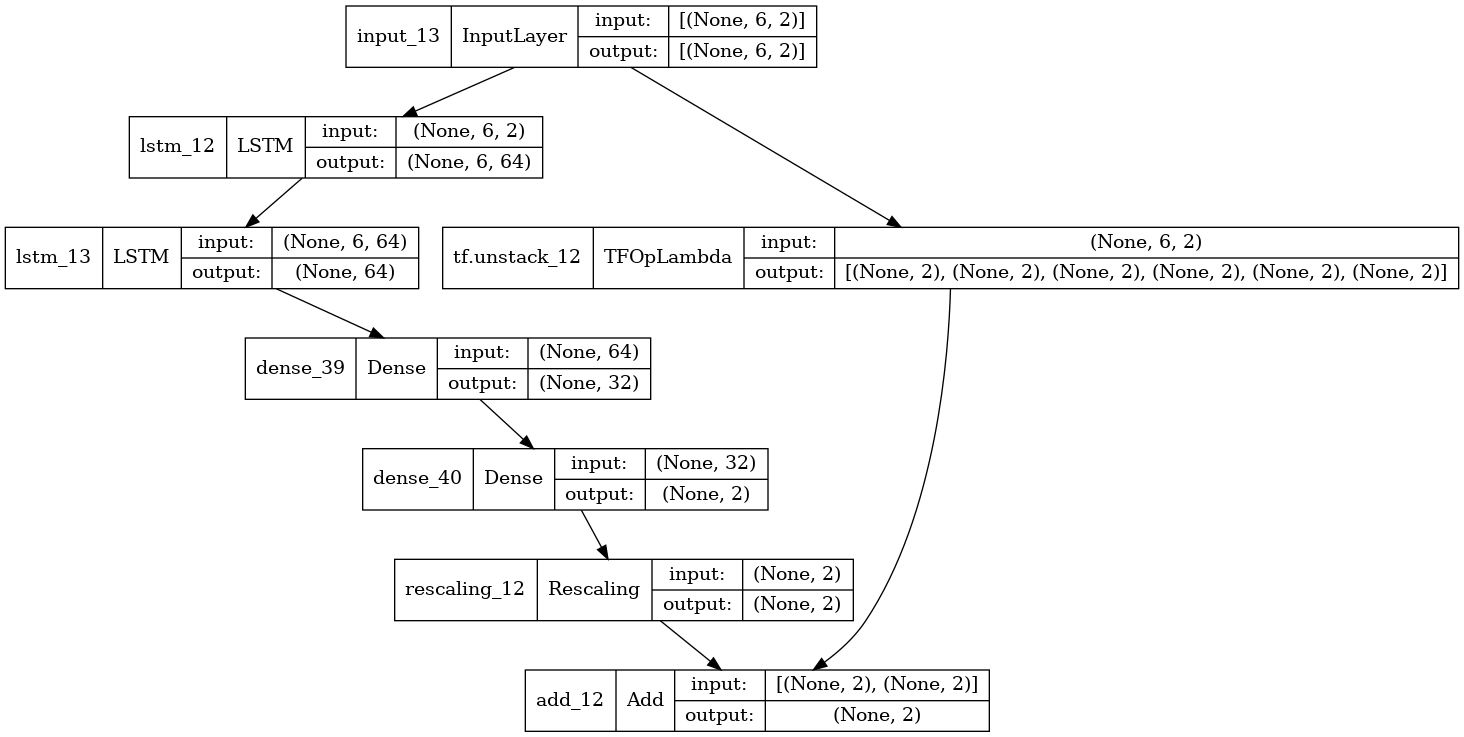

In [42]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for neural network integrator
nsteps = 6

use_LSTM = True

if use_LSTM: 
    dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                    keras.layers.LSTM(64),
                    keras.layers.Dense(32,activation='tanh')]
else:
    dense_layers = [keras.layers.Flatten(),
                    keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(64,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]


harmonic_oscillator = HarmonicOscillator(mass,k_spring)
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_verlet)
nn_integrator = NNIntegrator(harmonic_oscillator,nsteps,dt,
                             dense_layers)

# visualise the neural network model
nn_integrator.model.summary()
keras.utils.plot_model(nn_integrator.model, show_shapes=True)

The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [44]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.x[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.v[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
BATCH_SIZE=64
data_generator = DataGenerator(nn_integrator,verlet_integrator)
train_batches = data_generator.dataset.batch(BATCH_SIZE)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [45]:
EPOCHS=200
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

/home/eike/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
100/100 [==============================] - 18s 163ms/step - loss: 0.0172
Epoch 2/200
100/100 [==============================] - 16s 160ms/step - loss: 0.0018
Epoch 3/200
100/100 [==============================] - 16s 158ms/step - loss: 2.6774e-04
Epoch 4/200
100/100 [==============================] - 17s 169ms/step - loss: 2.4158e-04
Epoch 5/200
100/100 [==============================] - 17s 167ms/step - loss: 2.0838e-04
Epoch 6/200
100/100 [==============================] - 16s 162ms/step - loss: 1.5207e-04
Epoch 7/200
100/100 [==============================] - 16s 160ms/step - loss: 1.1782e-04
Epoch 8/200
100/100 [==============================] - 16s 160ms/step - loss: 8.5056e-05
Epoch 9/200
100/100 [==============================] - 16s 162ms/step - loss: 4.7852e-05
Epoch 10/200
100/100 [==============================] - 16s 165ms/step - loss: 4.0645e-05
Epoch 11/200
100/100 [==============================] - 16s 161ms/step - loss: 1.9813e-05
Epoch 12/200
100/100 [=====

100/100 [==============================] - 16s 160ms/step - loss: 3.5609e-07
Epoch 93/200
100/100 [==============================] - 16s 160ms/step - loss: 2.7035e-07
Epoch 94/200
100/100 [==============================] - 16s 161ms/step - loss: 8.5012e-07
Epoch 95/200
100/100 [==============================] - 16s 161ms/step - loss: 6.9214e-07
Epoch 96/200
100/100 [==============================] - 16s 161ms/step - loss: 4.9302e-07
Epoch 97/200
100/100 [==============================] - 17s 166ms/step - loss: 7.3442e-07
Epoch 98/200
100/100 [==============================] - 17s 165ms/step - loss: 1.7925e-07
Epoch 99/200
100/100 [==============================] - 16s 163ms/step - loss: 4.2693e-07
Epoch 100/200
100/100 [==============================] - 16s 163ms/step - loss: 5.4741e-07
Epoch 101/200
100/100 [==============================] - 16s 161ms/step - loss: 5.4321e-07
Epoch 102/200
100/100 [==============================] - 16s 159ms/step - loss: 4.0870e-07
Epoch 103/200
100/10

100/100 [==============================] - 16s 163ms/step - loss: 7.1353e-08
Epoch 183/200
100/100 [==============================] - 17s 166ms/step - loss: 8.6908e-08
Epoch 184/200
100/100 [==============================] - 17s 169ms/step - loss: 1.3110e-07
Epoch 185/200
100/100 [==============================] - 17s 171ms/step - loss: 1.1100e-07
Epoch 186/200
100/100 [==============================] - 16s 164ms/step - loss: 1.8685e-07
Epoch 187/200
100/100 [==============================] - 16s 161ms/step - loss: 9.5651e-08
Epoch 188/200
100/100 [==============================] - 16s 163ms/step - loss: 5.3552e-08
Epoch 189/200
100/100 [==============================] - 16s 162ms/step - loss: 7.1092e-08
Epoch 190/200
100/100 [==============================] - 16s 163ms/step - loss: 3.2386e-08
Epoch 191/200
100/100 [==============================] - 17s 166ms/step - loss: 1.3394e-07
Epoch 192/200
100/100 [==============================] - 17s 166ms/step - loss: 9.1351e-08
Epoch 193/200

## Loss function
![Loss function](./loss_history.png)

## Plot trajectories generated by Verlet integrator and neural network based integrator

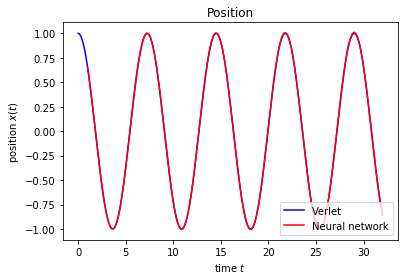

<Figure size 432x288 with 0 Axes>

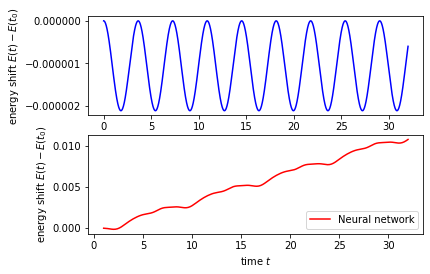

In [46]:
# Final time
T_final = 32

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 1.0
v[0] = 0.0
verlet_integrator.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet = []
x_verlet = []
E_verlet = []
while t<T_final:
    t_verlet.append(t)
    E_verlet.append(verlet_integrator.energy())
    x_verlet.append(verlet_integrator.x[0])
    verlet_integrator.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
v_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
verlet_integrator.set_state(x,v)
for k in range(nn_integrator.nsteps):    
    x_initial[k,:] = verlet_integrator.x[:]
    v_initial[k,:] = verlet_integrator.v[:]
    verlet_integrator.integrate(int(dt/dt_verlet))
nn_integrator.set_state(x_initial,v_initial)
t = (nn_integrator.nsteps-1)*nn_integrator.dt

# Timestepping loop
t_nn = []
x_nn = []
E_nn = []
while t<T_final:
    t_nn.append(t)
    x_nn.append(nn_integrator.x[0])
    E_nn.append(nn_integrator.energy())
    nn_integrator.integrate(1)
    t += dt

# Plot position as a function of time
plt.plot(t_verlet,x_verlet,label='Verlet',color='blue')
plt.plot(t_nn,x_nn,label='Neural network',color='red')
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position $x(t)$')
ax.set_title('Position')
plt.show()

plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)
fig, axs = plt.subplots(2,1)
axs[0].plot(t_verlet,E_verlet-E_verlet[0],label='Verlet',color='blue')
axs[1].plot(t_nn,E_nn-E_nn[0],label='Neural network',color='red')
plt.legend(loc='lower right')
for ax in axs:
    ax.set_xlabel('time $t$')
    ax.set_ylabel('energy shift $E(t)-E(t_0)$')
plt.show()